## Training demo for any model with custom loss function and SeismicDataLoader

In this demo, SeismicConvLSTM is used as the model and CustomLoss is used as the loss function.
- This demo uses train and validation dataloaders from dataloader.py. If you haven't seen dataloader_demo.ipynb, check it first.
- First, import train and validation dataloader
- Next, import custom loss function from customloss.py
- Next, we add SeismicConvLSTM model for demo purposes
- Next, import torch optimizer (we will use Adam, if you use other optimizers, import it)
- Then, we add matplotlib plt for traning, validation graph plotting
- Finally, add train_model function from trainer.py

In [1]:
from dataloader import train_dataloader, val_dataloader
from customLoss import CustomLoss
from convlstm import SeismicConvLSTM
import torch.optim as optim
import matplotlib.pyplot as plt
from trainer import train_model, train_model_with_logging

---------------- Dataset information: ----------------
[I] Sample rate: 100 Hz
[I] Chosen window size:900
[I] Hopping size:300
[I] Each sample is window_size/sample rate seconds long. Each sample has 3 channels.
[I] Dataset values shape is: [num_samples, num_window, num_channel, (height) 1, (width) num_sample_points]
[I] Dataset value shape: torch.Size([1575, 3, 3, 1, 900])
[I] Dataset labels shape is: [num_samples, 4], where the 4 values are [p_idx, s_idx, no_PS, only_P, only_S, both_PS]
[I] Dataset label shape:torch.Size([4725, 6])
[I] One sample shape: torch.Size([3, 3, 1, 900])
[I] One label shape: torch.Size([6])
[I] ----------------------------------------------------
[I] Some label examples in the dataset:
[I] Label: tensor([-1., -1.,  1.,  0.,  0.,  0.])
[I] Label: tensor([894.,  -1.,   0.,   1.,   0.,   0.])
[I] Label: tensor([359., 953.,   0.,   0.,   0.,   1.])
[I] Label: tensor([    1286.,       -1.,        0.,        1.,        0.,        0.])
[S] -------------------------

### Model setup

This below cell creates a model instance. If you'd like to use your own model, change this cell.
The example SeismicConvLSTM model takes the below inputs:
- input channel size
- output dimension
- numer of sequence windows
- data points in each window
- hidden dimensions of convlstm cells
- kernel size of conv layers
- number of convlstm cells

model variable is used to keep the model

In [2]:
# Define the model
# We are dynamically fetching the input channels, num_windows, data_points_of_each_window, and the output_dim from the dataset using the dataloader
# Create an iterator from the dataloader
train_iter = iter(train_dataloader)
# Get the first batch
one_sample = next(train_iter) # one_sample[0].shape, one_sample[1].shape --> torch.Size([16, 3, 3, 1, 900]) torch.Size([16, 6])

INPUT_CHANNELS = one_sample[0].shape[2] # one_sample[0].shape[2] --> 3
OUTPUT_DIM = one_sample[1].shape[1] # one_sample[1].shape[1] --> 6
NUM_WINDOWS = one_sample[0].shape[1] # one_sample[0].shape[1] --> 3
DATA_POINTS_OF_EACH_WINDOW = one_sample[0].shape[4] # one_sample[0].shape[4] --> 900
HIDDEN_DIM = [32, 32, 64, 64, 128]
KERNEL_SIZE = (11, 5, 3, 3, 3)   
NUM_CONVLSTM_BLOCKS = 5
print("output_dim: ", OUTPUT_DIM)
assert len(HIDDEN_DIM) == NUM_CONVLSTM_BLOCKS, "The number of hidden dimensions should be equal to the number of ConvLSTM blocks"
model = SeismicConvLSTM(input_dim=INPUT_CHANNELS, hidden_dim=HIDDEN_DIM, kernel_size=KERNEL_SIZE, num_layers=NUM_CONVLSTM_BLOCKS, output_dim=OUTPUT_DIM, num_windows = NUM_WINDOWS, data_points = DATA_POINTS_OF_EACH_WINDOW)

print(model)

output_dim:  6
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
SeismicConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(35, 128, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(96, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      )
      (3): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      )
      (4): ConvLSTMCell(
        (conv): Conv2d(192, 512, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      )
    )
  )
  (fc1): Linear(in_features=345600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


### Training the model
We have been created dataloaders and model. Now we will train the model with generic train function.
- First, initialize optimizer. In this demo, Adam optimizer is used with lr = LEARNING_RATE.
- Next, set the loss function as criterion. In this demo, CustomLoss function with lambda_val = CUSTOM_LOSS_LAMBDA is used.
- Then, set the number of epochs.
- Next, train the model. train_model function trains the model with train_dataloader, and validates after each epoch with val_dataloader

In [3]:
LEARNING_RATE = 0.1
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

CUSTOM_LOSS_LAMBDA = 2
criterion = CustomLoss(lambda_val=CUSTOM_LOSS_LAMBDA)

num_epochs = 30


# Train the model with the training dataloader
model, train_losses, val_losses = train_model_with_logging(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, 'train_log.csv') 


Epoch 0/29, Training Loss: 162128.0343
Validation Loss: 110170.7119
Epoch 1/29, Training Loss: 111701.9523
Validation Loss: 98560.1234
Epoch 2/29, Training Loss: 118002.1394
Validation Loss: 136867.4894
Epoch 3/29, Training Loss: 110772.2012
Validation Loss: 122846.9730
Epoch 4/29, Training Loss: 109953.9364
Validation Loss: 90460.4417
Epoch 5/29, Training Loss: 109947.9896
Validation Loss: 92894.5019
Epoch 6/29, Training Loss: 110589.2427
Validation Loss: 92617.8796
Epoch 7/29, Training Loss: 110674.1342
Validation Loss: 101912.1632
Epoch 8/29, Training Loss: 112495.3323
Validation Loss: 141975.0833
Epoch 9/29, Training Loss: 120622.7850
Validation Loss: 111001.0001
Epoch 10/29, Training Loss: 120127.1108
Validation Loss: 204857.5210
Epoch 11/29, Training Loss: 113920.5424
Validation Loss: 91232.2935
Epoch 12/29, Training Loss: 108212.4042
Validation Loss: 115203.3817
Epoch 13/29, Training Loss: 116945.6753
Validation Loss: 100699.1580
Epoch 14/29, Training Loss: 107406.3380
Validatio

Model saved at:  models/model_20241015-0002_epoch30_lr0.01_lambda2_windows3_datapoints900.pth


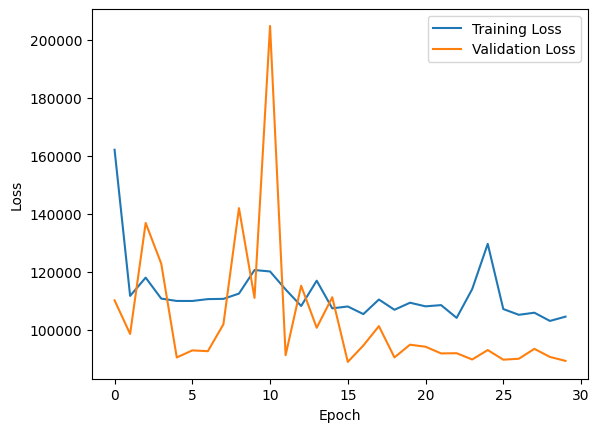

In [4]:
import os
import time
import torch

os.makedirs('models', exist_ok=True)
date_time_str = time.strftime("%Y%m%d-%H%M")
model_name = 'models/model_{}_epoch{}_lr{}_lambda{}_windows{}_datapoints{}.pth'.format(date_time_str, num_epochs, LEARNING_RATE, CUSTOM_LOSS_LAMBDA, NUM_WINDOWS, DATA_POINTS_OF_EACH_WINDOW)
torch.save(model.state_dict(), model_name)
print('Model saved at: ', model_name)

# plot and save the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('models/Train_and_val_loss_model_{}'.format(model_name.split('/')[1].split('.')[0]))
plt.show()